This notebook is being created to understand the BPI dataset, we are to understand the processes of loan application and how offers are accepted and declined and other cases related to that.

Analyse:

We will be discussing about the throughput times spent in every process from application submitted till cancellation of offer/refusal of the offer. The other aspect which will be discussed here will be the factors which causes delay in loan process and the frequency of incompleteness of loan applications.

Our target is to :

predict the time from application submitted to offer sent.

-----------------------------------------------------------------

Most of our hypothesis and visualizations will be intended to explore our target. 

-----------------------------------------------------------------

Column descriptions

Action : 
concept:name :: events happening for each of the case.
Event orgin : defines three general state changes for each event. general formation for concept:name.
Loan Goal : Reason for Loan Application.
Application Type: Whether the Application is New Credit or Limit Raise.
Credit Score: The Credit Score for the particular applicant. Credit score of some person represents how trustworthy that person is in terms of returning that specific bill or loan.
Requested Amount: How much amount has the Applicant Requested for loan.
firstwithdrawalamount : first transaction of loan(money) made by the customer

In [4]:
import numpy as np 
import pandas as pd
import pandas_profiling
import warnings
warnings.filterwarnings('ignore')
import datetime
from datetime import date

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import xgboost as xg
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [5]:
bpi = pd.read_csv('final_bpi.csv',parse_dates=['Timestamp'])
bpi.rename(columns = {'case:RequestedAmount':'RequestedAmount'}, inplace = True)

In [6]:
bpi

,Unnamed: 0,Timestamp,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,case:LoanGoal,case:ApplicationType,case:concept:name,RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID
0,0,2016-01-01 09:51:15.304000+00:00,Created,User_1,A_Create Application,Application,Application_652823628,complete,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2016-01-01 09:51:15.352000+00:00,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2016-01-01 09:51:15.774000+00:00,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2016-01-01 09:52:36.392000+00:00,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2016-01-01 09:52:36.403000+00:00,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202262,1202262,2017-01-06 06:33:02.212000+00:00,Deleted,User_1,W_Call after offers,Workflow,Workitem_1817549786,ate_abort,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1202263,1202263,2017-01-06 06:33:02.221000+00:00,Created,User_1,W_Call after offers,Workflow,Workitem_363876066,schedule,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1202264,1202264,2017-01-16 09:51:21.114000+00:00,statechange,User_28,A_Cancelled,Application,ApplState_1869071797,complete,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1202265,1202265,2017-01-16 09:51:21.139000+00:00,statechange,User_28,O_Cancelled,Offer,OfferState_420066181,complete,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_1580299144


In [7]:
bpi.describe(include='all')

,Unnamed: 0,Timestamp,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,case:LoanGoal,case:ApplicationType,case:concept:name,RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID
count,1.202267e+06,1202267,1202267,1202267,1202267,1202267,1202267,1202267,1202267,1202267,1202267,1.202267e+06,42995.000000,42995.000000,42995,42995.000000,42995,42995.000000,42995.000000,150854
unique,NaN,1202209,5,149,26,3,1202267,7,14,2,31509,NaN,NaN,NaN,2,NaN,2,NaN,NaN,42995
top,NaN,2016-10-18 07:33:51.174000+00:00,statechange,User_1,W_Validate application,Workflow,Workitem_1996187022,complete,Car,New credit,Application_1219772874,NaN,NaN,NaN,True,NaN,True,NaN,NaN,Offer_1447448624
freq,NaN,2,358940,148404,209496,768823,1,475306,339798,1083767,180,NaN,NaN,NaN,30136,NaN,21768,NaN,NaN,4
first,NaN,2016-01-01 09:51:15.304000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2017-02-01 14:11:03.499000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,6.011330e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.675947e+04,8394.338979,83.041982,NaN,281.403309,NaN,318.645912,18513.719940,NaN
std,3.470647e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.572320e+04,10852.443358,36.386199,NaN,192.577735,NaN,433.706216,13718.507416,NaN
min,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000,5.000000,NaN,43.050000,NaN,0.000000,5000.000000,NaN
25%,3.005665e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.000000e+03,0.000000,56.000000,NaN,152.820000,NaN,0.000000,8800.000000,NaN


<AxesSubplot:>

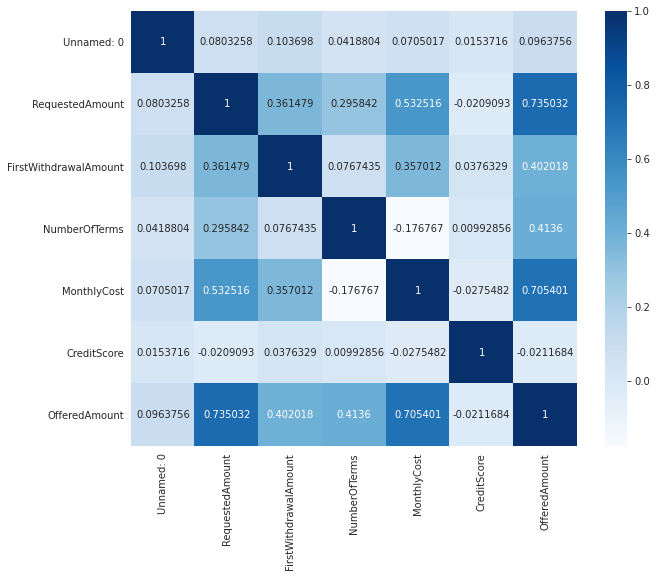

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
sns.heatmap(bpi.corr(),annot=True,cmap='Blues', fmt='g')

analyzing the factors which delay in loan process, frequency of incompletness in loan application and some other factors regarding time taken by other attributes and customer behaviour.

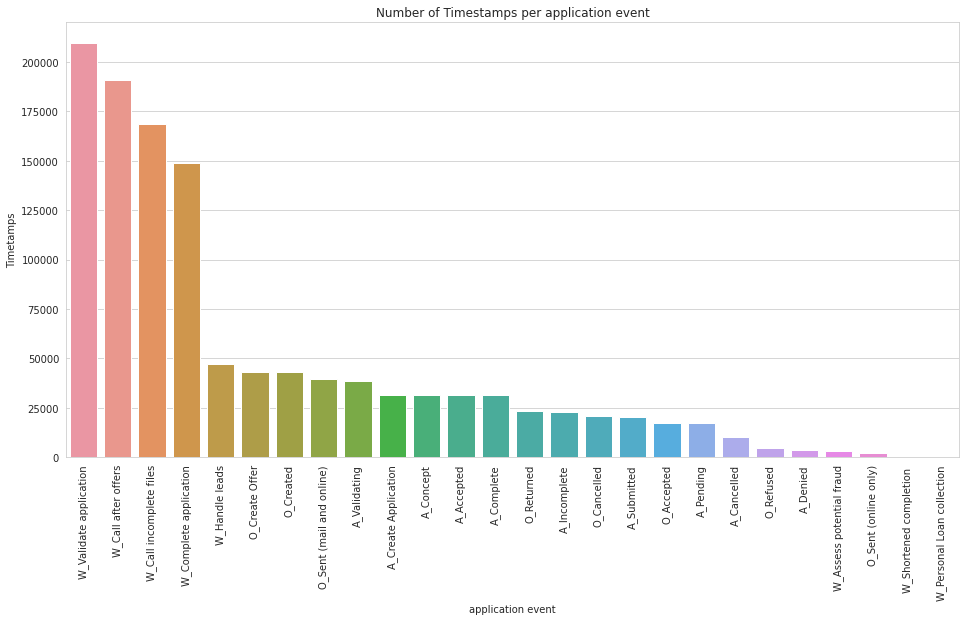

In [9]:
apptime=bpi.groupby('concept:name')['Timestamp'].count().sort_values(ascending=False)
plt.figure(figsize=(16,8))
ax = sns.barplot(x=apptime.index, y=apptime.values)
ax.set(ylabel="Timetamps", xlabel = "application event")
ax.set_title("Number of Timestamps per application event")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()
# it seems that event related to workflow are more likely to take significant amount of time since there is a 
# distinctive number of difference of timestamps belonging to Worklow and offer etc.
# w_validate_application event has taken the most time and w call after offers, this makes sense
# because validating the application has many steps and making the calls to the customer as part of worklow is a 
# time consuming task because once you make a call you have to wait a certain degree of time for their response to 
# come

# here we can notice our other question about incompleteness in loan application process like W_call incomplete
# files have frequency of 168529, the most frequenctly occuring event in the loan process at the third number.
# and A_incomplete has frequency of 23055 events out of 1202267 events.

In [10]:
bpi.groupby('EventOrigin').Timestamp.agg(['count']).sort_values(by=['count'],ascending=False)
# it is clear that work flow are more likely to take significant amount of time, they might be the cause of delay
# in the loan process as well
# event origin is the genernalized categorization of concept name which is more detailed categorized in 
# defining these three event origins. 

,count
EventOrigin,
Workflow,768823
Application,239595
Offer,193849


In [11]:
bpi.Selected.value_counts()

True     21768
False    21227
Name: Selected, dtype: int64

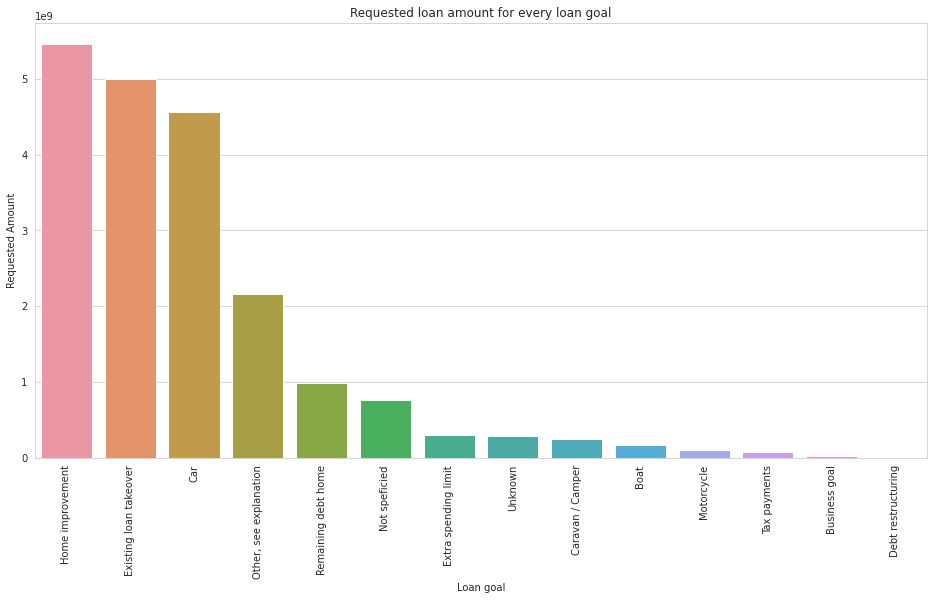

In [12]:
loanam=bpi.groupby('case:LoanGoal').RequestedAmount.sum().sort_values(ascending=False)
plt.figure(figsize=(16,8))
ax = sns.barplot(x=loanam.index, y=loanam.values)
ax.set(ylabel="Requested Amount", xlabel = "Loan goal")
ax.set_title("Requested loan amount for every loan goal")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()
# we were paritally right about our hypothesis, these are the same top three loan goals which have 
# taken most of the time. 
# large sums of money was request for these three loan goals, this also means that large requestedamount takes
# long time for loan application to process hence delaying the loan process for other loan goals as well.

In [13]:
# lets analyze if accepted offers take more time or unaccepted offers.
bpi.groupby('Accepted').Timestamp.agg(['count']).sort_values(by='count',ascending=False)
# from the results its quit clear that time taken by accepted offers was greater than the time taken by the 
# unaccepted offers, it implies that banks give priority to those application which are more likely to be accepted
# giving their customers more call offers and then waiting for their response. 

,count
Accepted,
True,30136
False,12859


In [14]:
# now we will discuss whether the acceptance rate had anything to do with credit score.
bpi.groupby('Accepted').CreditScore.agg(['sum']).sort_values(by='sum',ascending=False)
# it is as clear as day that people with greater creditscore were most likely to get their loan application
# accepted

,sum
Accepted,
True,11354610.0
False,2345571.0


In [15]:
# from the description of the dataset above that application have the largest number of events, we will try find
# out why.
larg=bpi[bpi['case:concept:name']=='Application_1219772874']
larg.head(50)

,Unnamed: 0,Timestamp,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,case:LoanGoal,case:ApplicationType,case:concept:name,RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID
266765,266765,2016-03-30 17:14:19.074000+00:00,Created,User_28,A_Create Application,Application,Application_1219772874,complete,Existing loan takeover,New credit,Application_1219772874,23500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
266766,266766,2016-03-30 17:14:19.086000+00:00,Created,User_28,W_Complete application,Workflow,Workitem_655634614,schedule,Existing loan takeover,New credit,Application_1219772874,23500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
266767,266767,2016-03-30 17:14:19.618000+00:00,Obtained,User_28,W_Complete application,Workflow,Workitem_845216581,start,Existing loan takeover,New credit,Application_1219772874,23500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
266768,266768,2016-03-30 17:14:19.622000+00:00,statechange,User_28,A_Concept,Application,ApplState_907448633,complete,Existing loan takeover,New credit,Application_1219772874,23500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
266769,266769,2016-03-30 17:21:15.708000+00:00,statechange,User_28,A_Accepted,Application,ApplState_1604055793,complete,Existing loan takeover,New credit,Application_1219772874,23500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
266770,266770,2016-03-30 17:22:29.948000+00:00,Created,User_28,O_Create Offer,Offer,Offer_1644876832,complete,Existing loan takeover,New credit,Application_1219772874,23500.0,0.0,117.0,True,250.0,False,0.0,23500.0,NaN
266771,266771,2016-03-30 17:22:31.400000+00:00,statechange,User_28,O_Created,Offer,OfferState_1285900382,complete,Existing loan takeover,New credit,Application_1219772874,23500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_1644876832
266772,266772,2016-03-30 17:23:09.042000+00:00,statechange,User_28,O_Sent (mail and online),Offer,OfferState_1632099067,complete,Existing loan takeover,New credit,Application_1219772874,23500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_1644876832
266773,266773,2016-03-30 17:23:09.070000+00:00,Deleted,User_28,W_Complete application,Workflow,Workitem_703481355,complete,Existing loan takeover,New credit,Application_1219772874,23500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
266774,266774,2016-03-30 17:23:09.215000+00:00,Created,User_28,W_Call after offers,Workflow,Workitem_228744971,schedule,Existing loan takeover,New credit,Application_1219772874,23500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
summ=larg.groupby('concept:name').sum().sort_values(by='RequestedAmount',ascending=False)
summ
# this table tell many things about the targetted application
# the amount requested by the applicant when the calls were made to the customer for the incomplete files. 
# offered amount at the offer creation was far less than the requested amounts. the customer must have decided to
# not cooperate any longer.

,Unnamed: 0,RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,MonthlyCost,CreditScore,OfferedAmount
concept:name,,,,,,,
W_Call incomplete files,26686631,2350000.0,0.0,0.0,0.00,0.0,0.0
W_Validate application,10140538,893000.0,0.0,0.0,0.00,0.0,0.0
W_Call after offers,2667793,235000.0,0.0,0.0,0.00,0.0,0.0
A_Incomplete,1334228,117500.0,0.0,0.0,0.00,0.0,0.0
A_Validating,1334183,117500.0,0.0,0.0,0.00,0.0,0.0
O_Created,800521,70500.0,0.0,0.0,0.00,0.0,0.0
W_Complete application,800306,70500.0,0.0,0.0,0.00,0.0,0.0
O_Sent (mail and online),800524,70500.0,0.0,0.0,0.00,0.0,0.0
O_Create Offer,800518,70500.0,194.0,354.0,743.28,907.0,70500.0


In [17]:
larg['concept:name'].value_counts()
# one of the reason of large event occurence must be the worflow call incomplete files, that means that loan
# application files submitted by this client were mostly incomplete so bank had to call him for incomplete files
# 100 times.
# the resulting observation is that client who submit incomplete application files will have to face more trials
# resulting in delay in their loan process and others as well.

W_Call incomplete files     100
W_Validate application       38
W_Call after offers          10
A_Incomplete                  5
A_Validating                  5
W_Complete application        3
O_Created                     3
O_Sent (mail and online)      3
O_Create Offer                3
O_Returned                    2
O_Cancelled                   2
A_Concept                     1
A_Accepted                    1
O_Accepted                    1
A_Complete                    1
A_Pending                     1
A_Create Application          1
Name: concept:name, dtype: int64

the above section end here, now we will analysing the thoughput time from application submitted to application
sent and we will also produce our label feature "days" (from application submitted to offer sent)

In [18]:
# first we will try analyse the 
a_submitted = bpi[bpi['concept:name'] == 'A_Submitted']
offer_sent = bpi[bpi['concept:name'] == 'O_Sent (mail and online)']
offer_sent

,Unnamed: 0,Timestamp,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,case:LoanGoal,case:ApplicationType,case:concept:name,RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID
11,11,2016-01-02 11:30:28.606000+00:00,statechange,User_52,O_Sent (mail and online),Offer,OfferState_2051164740,complete,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_148581083
52,52,2016-01-02 11:03:05.300000+00:00,statechange,User_38,O_Sent (mail and online),Offer,OfferState_618588716,complete,Home improvement,New credit,Application_1691306052,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_1669071500
81,81,2016-01-02 11:06:53.268000+00:00,statechange,User_19,O_Sent (mail and online),Offer,OfferState_253970058,complete,Home improvement,New credit,Application_428409768,15000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_1209840642
90,90,2016-01-02 11:26:19.140000+00:00,statechange,User_19,O_Sent (mail and online),Offer,OfferState_600565321,complete,Home improvement,New credit,Application_428409768,15000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_997411923
137,137,2016-01-04 17:23:02.522000+00:00,statechange,User_19,O_Sent (mail and online),Offer,OfferState_644503319,complete,Car,New credit,Application_1746793196,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_1319158006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202126,1202126,2017-01-02 13:34:22.594000+00:00,statechange,User_84,O_Sent (mail and online),Offer,OfferState_422629821,complete,Existing loan takeover,New credit,Application_2103458006,15000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_1395096354
1202127,1202127,2017-01-02 13:34:22.596000+00:00,statechange,User_84,O_Sent (mail and online),Offer,OfferState_103171006,complete,Existing loan takeover,New credit,Application_2103458006,15000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_682062790
1202152,1202152,2017-01-02 19:13:09.821000+00:00,statechange,User_84,O_Sent (mail and online),Offer,OfferState_689442753,complete,Home improvement,New credit,Application_59622033,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_1445809476
1202204,1202204,2017-01-04 19:36:01.262000+00:00,statechange,User_84,O_Sent (mail and online),Offer,OfferState_1715285048,complete,Car,New credit,Application_303923658,30000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_1734870628


In [19]:
offer_submit=a_submitted['concept:name'].agg(['count'])
offer_submit
# number of application submitted

count    20423
Name: concept:name, dtype: int64

In [20]:
offer_cent=offer_sent['concept:name'].agg(['count'])
offer_cent
# number of offers sent
# number of offers are as twice as the number of application submitted, this is quit understandable because banks
# can send multiple offers to their potential applicant to make them their customer

count    39707
Name: concept:name, dtype: int64

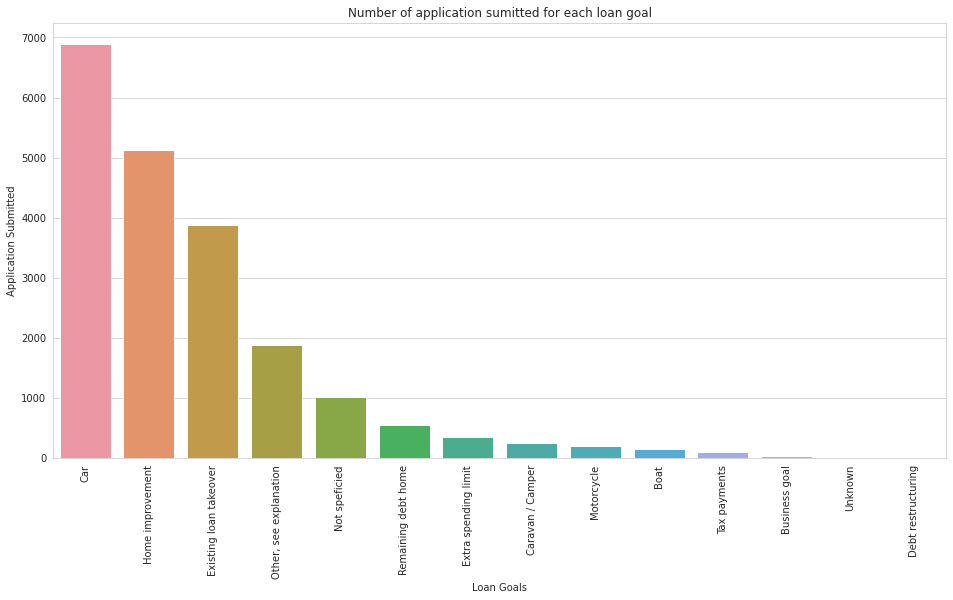

In [21]:
sub=a_submitted.groupby('case:LoanGoal')['concept:name'].count().sort_values(ascending=False)
plt.figure(figsize=(16,8))
ax = sns.barplot(x=sub.index, y=sub.values)
ax.set(ylabel="Application Submitted", xlabel = "Loan Goals")
ax.set_title("Number of application sumitted for each loan goal")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

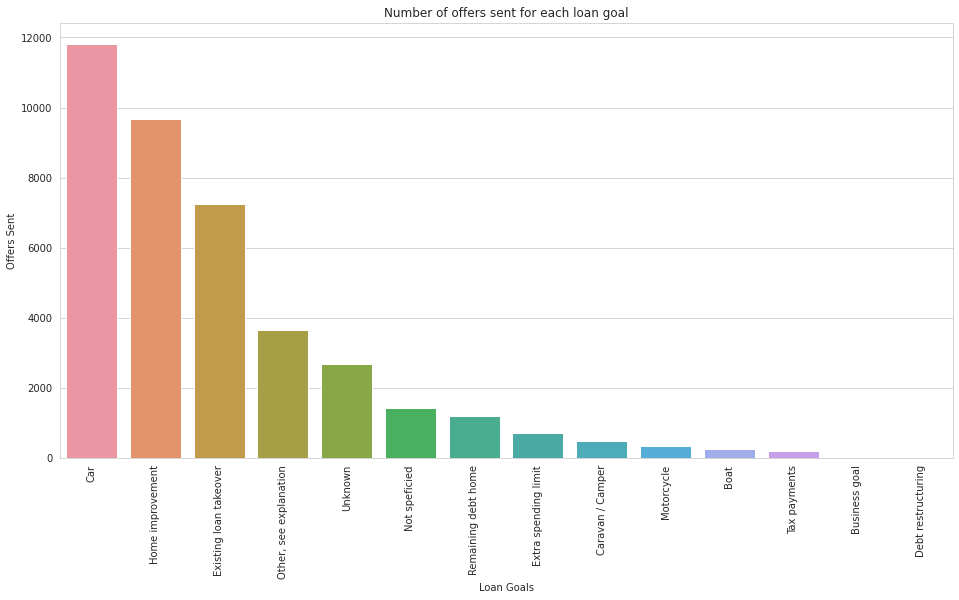

In [22]:
ofs=offer_sent.groupby('case:LoanGoal')['concept:name'].count().sort_values(ascending=False)
plt.figure(figsize=(16,8))
ax = sns.barplot(x=ofs.index, y=ofs.values)
ax.set(ylabel="Offers Sent", xlabel = "Loan Goals")
ax.set_title("Number of offers sent for each loan goal")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

Feature engineering for label column "days"

In [23]:
subdays=[]
time_int=a_submitted['Timestamp'].dt.strftime("%Y%m%d").astype(int)
time_int1=offer_sent['Timestamp'].dt.strftime("%Y%m%d").astype(int)

for a,o in zip(time_int,time_int1):

    d0 = date(int(str(a)[0:4]),int(str(a)[4:6]),int(str(a)[6:8]))
    d1 = date(int(str(o)[0:4]),int(str(o)[4:6]),int(str(o)[6:8]))
    delta = d1 - d0
    subdays.append(abs(delta.days))
days=pd.DataFrame(subdays,columns=['Days'])
days

,Days
0,1
1,1
2,1
3,1
4,3
...,...
20418,170
20419,164
20420,169
20421,170


In [24]:
series=[]
for i in range(20423,1202267):
    series.append(i)
pred_df=bpi
r_days=np.random.randint(80,150,size=1181844,)

s_days=pd.Series(r_days,index=series)

pred_df['Days']=days
pred_df['Days'].fillna(value=s_days,inplace=True,)
pred_df['Days']=pred_df['Days'].astype(int)
pred_df['Days'][20423:1202267]

20423      137
20424       96
20425      107
20426      133
20427       84
          ... 
1202262     83
1202263    132
1202264     82
1202265    112
1202266    140
Name: Days, Length: 1181844, dtype: int64

In [25]:
pred_df['Days'].isna().sum()

0

In [26]:
pred_df['week'] = pred_df['Timestamp'].dt.strftime("%G_WK%V")

In [27]:
pred_df

,Unnamed: 0,Timestamp,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,case:LoanGoal,case:ApplicationType,...,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID,Days,week
0,0,2016-01-01 09:51:15.304000+00:00,Created,User_1,A_Create Application,Application,Application_652823628,complete,Existing loan takeover,New credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2015_WK53
1,1,2016-01-01 09:51:15.352000+00:00,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,Existing loan takeover,New credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2015_WK53
2,2,2016-01-01 09:51:15.774000+00:00,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,Existing loan takeover,New credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2015_WK53
3,3,2016-01-01 09:52:36.392000+00:00,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,Existing loan takeover,New credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2015_WK53
4,4,2016-01-01 09:52:36.403000+00:00,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,Existing loan takeover,New credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2015_WK53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202262,1202262,2017-01-06 06:33:02.212000+00:00,Deleted,User_1,W_Call after offers,Workflow,Workitem_1817549786,ate_abort,Home improvement,New credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83,2017_WK01
1202263,1202263,2017-01-06 06:33:02.221000+00:00,Created,User_1,W_Call after offers,Workflow,Workitem_363876066,schedule,Home improvement,New credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,132,2017_WK01
1202264,1202264,2017-01-16 09:51:21.114000+00:00,statechange,User_28,A_Cancelled,Application,ApplState_1869071797,complete,Home improvement,New credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82,2017_WK03
1202265,1202265,2017-01-16 09:51:21.139000+00:00,statechange,User_28,O_Cancelled,Offer,OfferState_420066181,complete,Home improvement,New credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_1580299144,112,2017_WK03


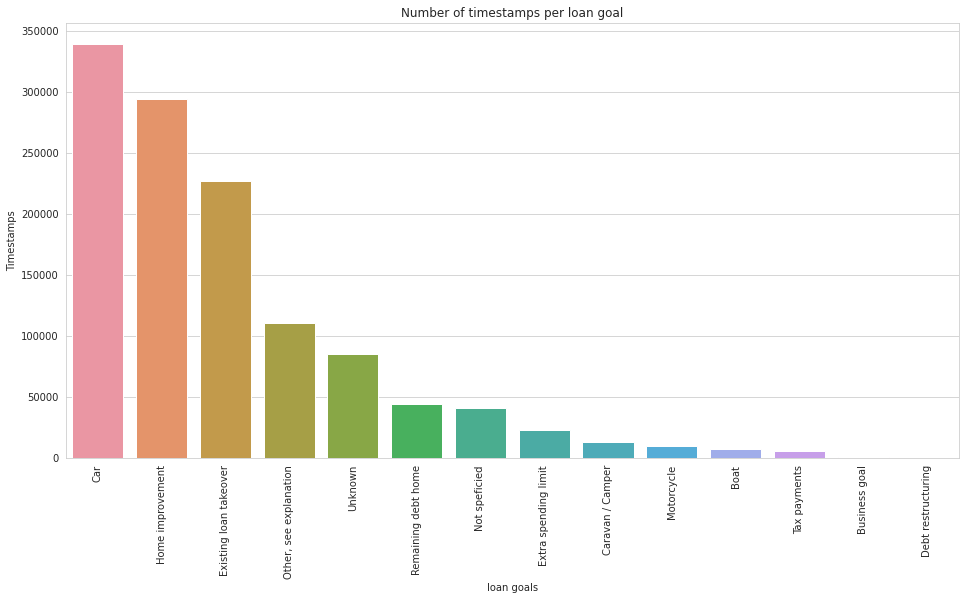

In [28]:
loantime=bpi.groupby('case:LoanGoal').Timestamp.count().sort_values(ascending=False)[0:20436]
plt.figure(figsize=(16,8))
ax = sns.barplot(x=loantime.index, y=loantime.values)
ax.set(ylabel="Timestamps", xlabel = "loan goals")
ax.set_title("Number of timestamps per loan goal")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()
# the top three loan goals here seems to take most of the time but why ? does it have something to do with 
# the amount of money they request ? let's find out.

<AxesSubplot:>

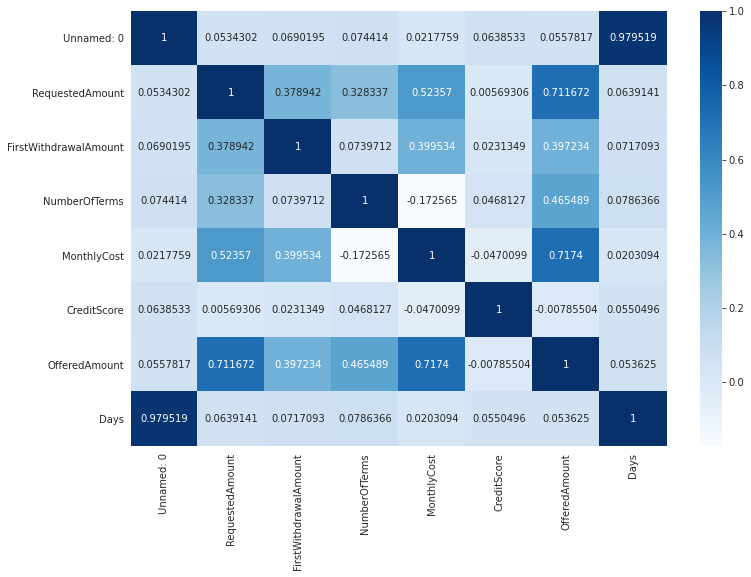

In [29]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
sns.heatmap(pred_df[0:20423].corr(),annot=True,cmap='Blues', fmt='g')

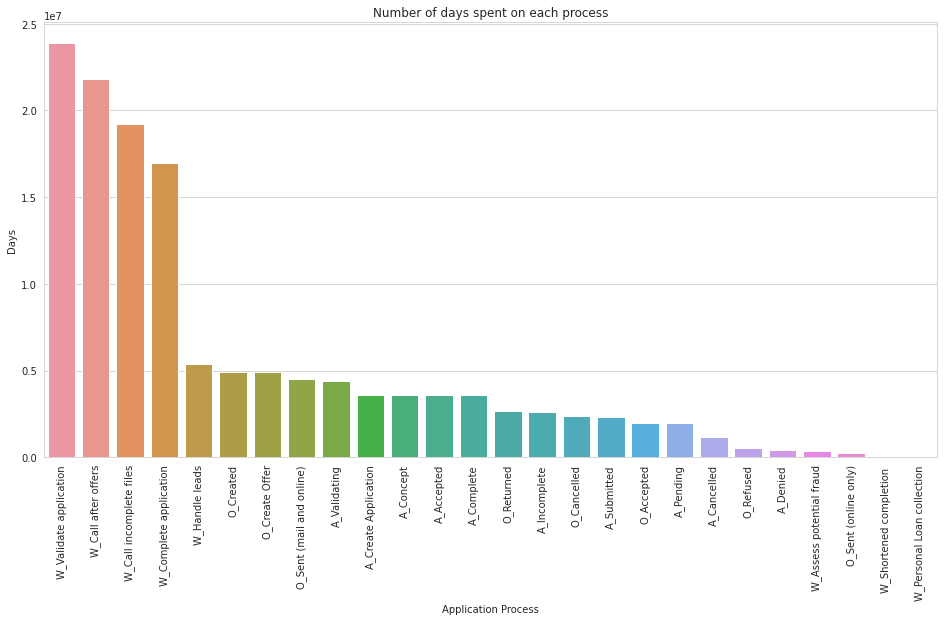

In [30]:
days=bpi.groupby('concept:name').Days.sum().sort_values(ascending=False)
plt.figure(figsize=(16,8))
ax = sns.barplot(x=days.index, y=days.values)
ax.set(ylabel="Days", xlabel = "Application Process")
ax.set_title("Number of days spent on each process")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

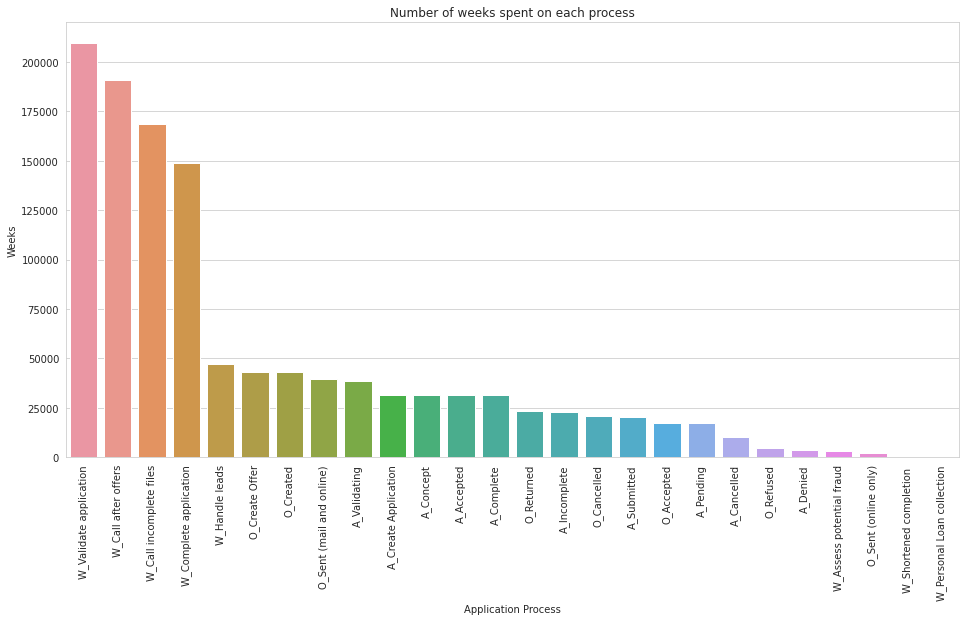

In [31]:
weeks=bpi.groupby('concept:name').week.count().sort_values(ascending=False)
plt.figure(figsize=(16,8))
ax = sns.barplot(x=weeks.index, y=weeks.values)
ax.set(ylabel="Weeks", xlabel = "Application Process")
ax.set_title("Number of weeks spent on each process")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [32]:
# How many applications are created per week?
app=bpi[bpi['concept:name']=='A_Create Application']
week_apps=app.groupby('week')['case:concept:name'].count()

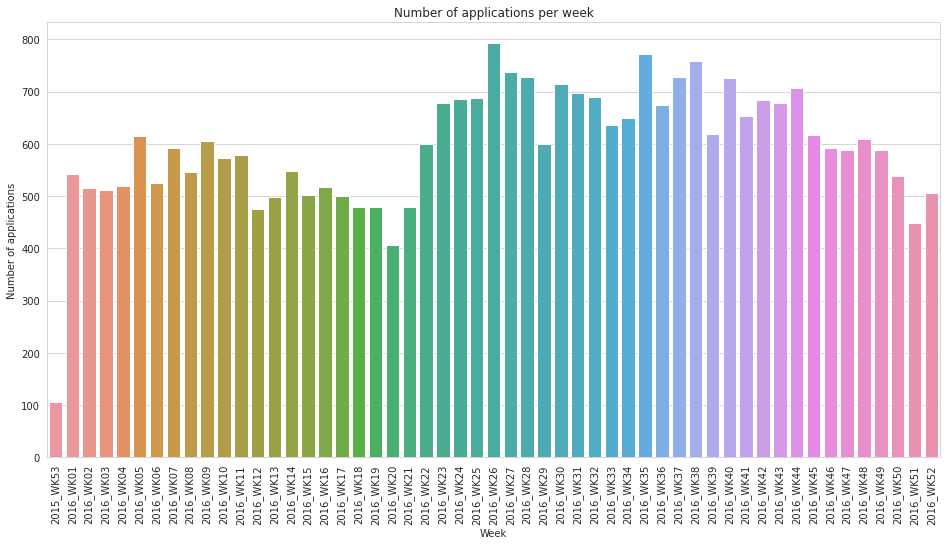

In [33]:
plt.figure(figsize=(16,8))
ax = sns.barplot(x=week_apps.index, y=week_apps.values)
ax.set(ylabel="Number of applications", xlabel = "Week")
ax.set_title("Number of applications per week")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [34]:
# What is the total number of successful applications per week?
succ=bpi[bpi['concept:name']=='A_Accepted']
week_succ=succ.groupby('week')['case:concept:name'].count()

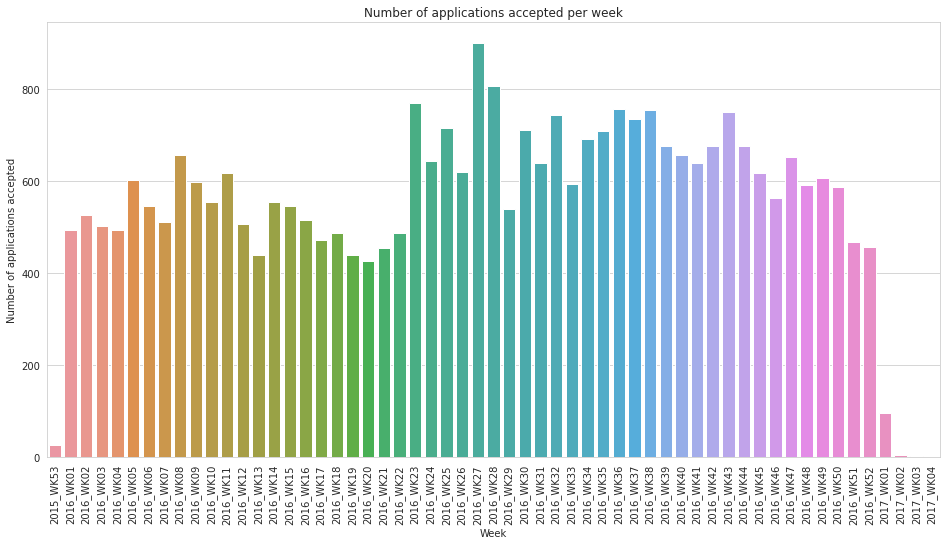

In [35]:
plt.figure(figsize=(16,8))
ax = sns.barplot(x=week_succ.index, y=week_succ.values)
ax.set(ylabel="Number of applications accepted", xlabel = "Week")
ax.set_title("Number of applications accepted per week")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

this section ends here, Now we analyze the offers that have been accepted and have not been accepted

In [36]:
accepted = bpi[bpi['Accepted'] == True]
unaccepted = bpi[bpi['Accepted'] == False]
# getting cases which have been accepted and unaccepted 

In [37]:
accepted.head(5)

,Unnamed: 0,Timestamp,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,case:LoanGoal,case:ApplicationType,...,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID,Days,week
9,9,2016-01-02 11:29:03.994000+00:00,Created,User_52,O_Create Offer,Offer,Offer_148581083,complete,Existing loan takeover,New credit,...,20000.0,44.0,True,498.29,True,979.0,20000.0,NaN,1,2015_WK53
79,79,2016-01-02 11:05:15.942000+00:00,Created,User_19,O_Create Offer,Offer,Offer_1209840642,complete,Home improvement,New credit,...,15000.0,120.0,True,158.98,False,0.0,15000.0,NaN,1,2015_WK53
87,87,2016-01-02 11:25:44.202000+00:00,Created,User_19,O_Create Offer,Offer,Offer_997411923,complete,Home improvement,New credit,...,15000.0,120.0,True,158.98,True,1059.0,15000.0,NaN,0,2015_WK53
208,208,2016-01-02 11:42:23.751000+00:00,Created,User_19,O_Create Offer,Offer,Offer_607758096,complete,Home improvement,New credit,...,35000.0,120.0,True,366.08,False,0.0,35000.0,NaN,1,2015_WK53
231,231,2016-01-02 11:43:26.149000+00:00,Created,User_17,O_Create Offer,Offer,Offer_213805292,complete,Existing loan takeover,New credit,...,400.0,120.0,True,143.91,False,0.0,13000.0,NaN,23,2015_WK53


In [38]:
accepted[accepted['RequestedAmount']==accepted['OfferedAmount']]['Accepted'].value_counts()
# there is a large acceptence rate when the requested amount is equal to offered 

True    20939
Name: Accepted, dtype: int64

In [39]:
unaccepted[unaccepted['RequestedAmount']==unaccepted['OfferedAmount']]['Accepted'].value_counts()
# when the requested amount is equal to offered amount the unaccepted rate was lower as compared figure above

False    7954
Name: Accepted, dtype: int64

In [40]:
# need find out what was acceptance rate when requestedamount was greater than the offeredamount and vice versa
# and compare the figures.
accepted[accepted['RequestedAmount']>accepted['OfferedAmount']]['Accepted'].value_counts()
# we have 2630 accepted cases 

True    2630
Name: Accepted, dtype: int64

In [41]:
# need find out what was acceptance rate when requestedamount was lesser than the offeredamount
accepted[accepted['RequestedAmount']<accepted['OfferedAmount']]['Accepted'].value_counts()
# we have 6567 cases 
# it's logicaly quit understandable that bank prefers someone who requests amount lesser than the amount offered
# by the bank

True    6567
Name: Accepted, dtype: int64

In [42]:
# need to find out what was unacceptance rate when requestedamount was greater than the offeredamount and vice 
# versa and compare the figures.
unaccepted[unaccepted['RequestedAmount']>unaccepted['OfferedAmount']]['Accepted'].value_counts()

False    2152
Name: Accepted, dtype: int64

In [43]:
unaccepted[unaccepted['RequestedAmount']<unaccepted['OfferedAmount']]['Accepted'].value_counts()
# there is a small diference between these two figures in the unaccepted cases, more amount of cases 
# were refused even when the requested amount was lesser than offer amount, and unaccepted cases were lower even
# though requestedamount was greater than the offeredamount

False    2753
Name: Accepted, dtype: int64

In [44]:
success_app=accepted.groupby('case:concept:name').Accepted.agg(['count']).sort_values(by=['count'],ascending=False)
success_app.head(10)
# application with the most accepted cases Application_423354116 	10 we will analyze this application 
# specifically to understand the behaviour of acceptance in the loan process

,count
case:concept:name,
Application_423354116,10
Application_783041368,8
Application_272003201,8
Application_1933550065,8
Application_1295329022,8
Application_697272539,8
Application_2121832198,8
Application_1268984213,8
Application_504178547,8


In [45]:
best_app=bpi[bpi['case:concept:name']=='Application_423354116']
best_app

,Unnamed: 0,Timestamp,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,case:LoanGoal,case:ApplicationType,...,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID,Days,week
1067878,1067878,2016-11-17 15:25:29.080000+00:00,Created,User_54,A_Create Application,Application,Application_423354116,complete,Unknown,New credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123,2016_WK46
1067879,1067879,2016-11-17 15:25:29.088000+00:00,Created,User_54,W_Complete application,Workflow,Workitem_1219692614,schedule,Unknown,New credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,108,2016_WK46
1067880,1067880,2016-11-17 15:25:29.091000+00:00,Obtained,User_54,W_Complete application,Workflow,Workitem_1544142341,start,Unknown,New credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115,2016_WK46
1067881,1067881,2016-11-17 15:25:29.093000+00:00,statechange,User_54,A_Concept,Application,ApplState_56760340,complete,Unknown,New credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,2016_WK46
1067882,1067882,2016-11-17 15:29:55.266000+00:00,statechange,User_54,A_Accepted,Application,ApplState_521029274,complete,Unknown,New credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120,2016_WK46
1067883,1067883,2016-11-17 15:38:35.919000+00:00,Created,User_54,O_Create Offer,Offer,Offer_549643015,complete,Unknown,New credit,...,15000.0,112.0,True,376.97,False,0.0,35000.0,NaN,149,2016_WK46
1067884,1067884,2016-11-17 15:38:36.483000+00:00,statechange,User_54,O_Created,Offer,OfferState_608878918,complete,Unknown,New credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_549643015,97,2016_WK46
1067885,1067885,2016-11-17 15:38:56.453000+00:00,Created,User_54,O_Create Offer,Offer,Offer_1876747821,complete,Unknown,New credit,...,12000.0,112.0,True,344.66,False,0.0,32000.0,NaN,143,2016_WK46
1067886,1067886,2016-11-17 15:38:57.094000+00:00,statechange,User_54,O_Created,Offer,OfferState_1780516109,complete,Unknown,New credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_1876747821,94,2016_WK46
1067887,1067887,2016-11-17 15:39:11.183000+00:00,Created,User_54,O_Create Offer,Offer,Offer_945635983,complete,Unknown,New credit,...,10000.0,112.0,True,323.12,False,0.0,30000.0,NaN,80,2016_WK46


<AxesSubplot:>

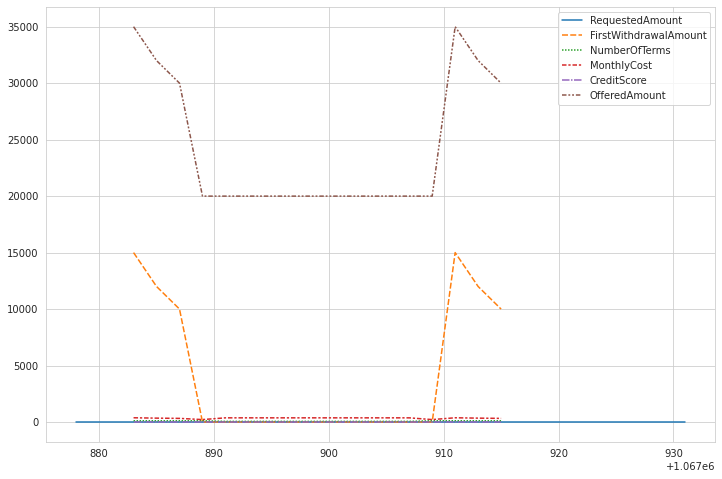

In [46]:
plt.figure(figsize=(12,8))
data=[best_app['RequestedAmount'],best_app['FirstWithdrawalAmount'],best_app['NumberOfTerms'],
      best_app['MonthlyCost'],best_app['CreditScore'],best_app['OfferedAmount']]
sns.lineplot(data=data)
# the secret of his acceptance comes from offers he got from the bank as per his application for the loan
# but he has no creditscore whatsoever, might be because his loan goals are unknown. 
# his application types are all new credit, most of his application lifecycles are complete and he has good number 
# of offers 
# interestingly in the graph the OfferedAmount and FirstWithdrawalAmount are of the same pattern here, it implies
# that the applicant after each offered amount makes a firstwithdrawal of atleast 33% out of the amount offered.
# and leaves the rest. 

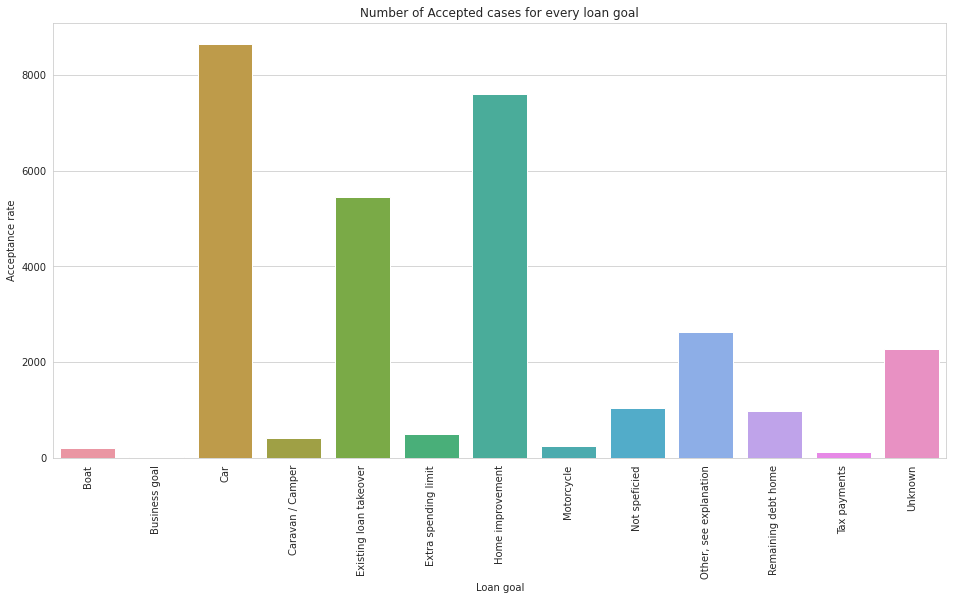

In [47]:
loan_goals=accepted.groupby('case:LoanGoal').Accepted.count()
loan_goals
# customers who wanted to buy Car had the highest case acceptance 
plt.figure(figsize=(16,8))
ax = sns.barplot(x=loan_goals.index, y=loan_goals.values)
ax.set(ylabel="Acceptance rate", xlabel = "Loan goal")
ax.set_title("Number of Accepted cases for every loan goal")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

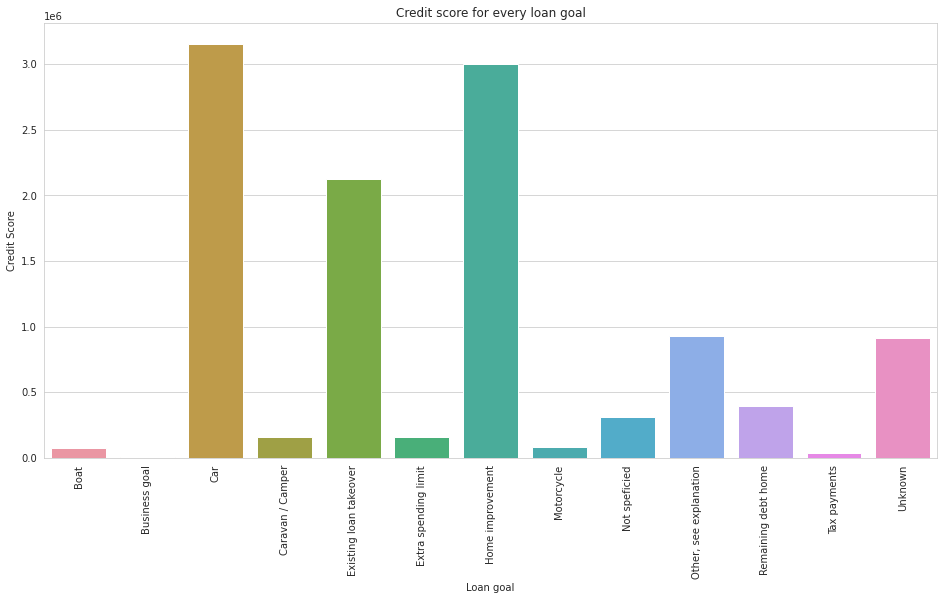

In [107]:
# earlier in the section we understood that the applicants with the greater creditscore were more likely to get
# accepted again, if the accept rate of car loan goal is higher than anyone, does it correlate with creditscore
# as well ?
cr=accepted.groupby('case:LoanGoal').CreditScore.sum()
plt.figure(figsize=(16,8))
ax = sns.barplot(x=cr.index, y=cr.values)
ax.set(ylabel="Credit Score", xlabel = "Loan goal")
ax.set_title("Credit score for every loan goal")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()
# we were right, customers whose loan goal was to get car have the highest credit score that's why their accetance
# rate was higher as well.

In [49]:
app_type=accepted.groupby('case:ApplicationType').Accepted.agg(['count']).sort_values(by=['count'],ascending=False)
app_type
# 

,count
case:ApplicationType,
New credit,27306
Limit raise,2830


In [50]:
app_credit=accepted.groupby('case:LoanGoal').CreditScore.agg(['sum']).sort_values(by=['sum'],ascending=False)
app_credit
# customer who took loan for car, home improvement and existing loan takeover were more loyal 
# in returning the bills and loans

,sum
case:LoanGoal,
Car,3155817.0
Home improvement,3004041.0
Existing loan takeover,2128547.0
"Other, see explanation",932622.0
Unknown,910926.0
Remaining debt home,395684.0
Not speficied,308262.0
Extra spending limit,160341.0
Caravan / Camper,155912.0


In [51]:
unsuccess_app=unaccepted.groupby('case:concept:name').Accepted.agg(['count']).sort_values(by=['count'],ascending=False)
unsuccess_app.head(10)
# lets just take the top one to analyze why this loan application was not accepted 

,count
case:concept:name,
Application_1867093856,7
Application_1142548986,7
Application_96457854,7
Application_287203067,7
Application_1193197506,7
Application_1946698804,7
Application_1952344243,6
Application_352411555,6
Application_1432738029,6


In [52]:
fail_app=bpi[bpi['case:concept:name']=='Application_1867093856']
fail_app

,Unnamed: 0,Timestamp,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,case:LoanGoal,case:ApplicationType,...,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID,Days,week
883958,883958,2016-09-27 10:26:04.231000+00:00,Created,User_60,A_Create Application,Application,Application_1867093856,complete,Existing loan takeover,New credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,141,2016_WK39
883959,883959,2016-09-27 10:26:04.238000+00:00,Created,User_60,W_Complete application,Workflow,Workitem_140999548,schedule,Existing loan takeover,New credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80,2016_WK39
883960,883960,2016-09-27 10:26:04.242000+00:00,Obtained,User_60,W_Complete application,Workflow,Workitem_465967545,start,Existing loan takeover,New credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80,2016_WK39
883961,883961,2016-09-27 10:26:04.244000+00:00,statechange,User_60,A_Concept,Application,ApplState_1165029856,complete,Existing loan takeover,New credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,138,2016_WK39
883962,883962,2016-09-27 10:30:08.741000+00:00,statechange,User_60,A_Accepted,Application,ApplState_277347391,complete,Existing loan takeover,New credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111,2016_WK39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884068,884068,2016-11-02 15:01:11.582000+00:00,statechange,User_29,O_Cancelled,Offer,OfferState_1108410496,complete,Existing loan takeover,New credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_2118807923,135,2016_WK44
884069,884069,2016-11-02 15:01:11.593000+00:00,statechange,User_29,O_Cancelled,Offer,OfferState_1331678337,complete,Existing loan takeover,New credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_1075553081,99,2016_WK44
884070,884070,2016-11-02 15:01:11.602000+00:00,statechange,User_29,O_Cancelled,Offer,OfferState_409154003,complete,Existing loan takeover,New credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_725759836,114,2016_WK44
884071,884071,2016-11-02 15:01:11.609000+00:00,statechange,User_29,O_Cancelled,Offer,OfferState_632126150,complete,Existing loan takeover,New credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_356670945,86,2016_WK44


In [53]:
fail_app['concept:name'].value_counts()

W_Call incomplete files     38
W_Validate application      18
O_Created                    9
O_Create Offer               9
O_Cancelled                  8
W_Call after offers          6
O_Sent (online only)         5
O_Sent (mail and online)     4
A_Validating                 4
A_Incomplete                 3
W_Complete application       3
O_Returned                   2
O_Accepted                   1
A_Complete                   1
A_Concept                    1
A_Pending                    1
A_Accepted                   1
A_Create Application         1
Name: concept:name, dtype: int64

In [54]:
# he has no creditscore same as the most accepted applicant, his loan goals are only loan takeover.
# his application types are all new credit, most of his application lifecycles are complete
# but the main reason of unaccpetance of application might be the W_call incomplete files as shown above

In [55]:
unaccepted.groupby('case:LoanGoal').Accepted.agg(['count']).sort_values(by='count',ascending=False)
# unaccepted cases for each loan goal

,count
case:LoanGoal,
Car,3976
Home improvement,2805
Existing loan takeover,2427
"Other, see explanation",1316
Unknown,840
Not speficied,508
Remaining debt home,354
Extra spending limit,276
Motorcycle,112


predicting the time from application submitted to offer sent.

potential features of interest:
1. Timestamp
2. concept:name
3. case:LoanGoal
4. case:concept:name
5. RequestedAmount
6. Accepted
7. MonthlyCost
8. CreditScore
9. OfferedAmount

Feature details
1. W_Validate application , W_Call after offers , W_Call incomplete files , W_Complete application (concept:name) took the most time being related to workflow.
2. Workflow 768823 Application 239595 Offer 193849 | workflow takes the most time but application and offer are important as well. (EventOrigin)
3. Car, Home, and existing loan takover LoanGoal takes the most time in the LoanGoal and this is partially correlated to Requested amount as well (case:LoanGoal), the larger the amount requested for loan goal greater the time will be to process that application. 
4. Accepted applications have taken more time than unaccepted applications (Accepted)
5. people with greater creditscore were most likely to get their loan application accepted
6. W_Validate application , W_Call after offers , W_Call incomplete files , W_Complete application have taken the most of the weeks

starting the feature engineering for predicting the time from application submitted to offer sent.

In [56]:
df_model=(pred_df[['concept:name','case:LoanGoal','RequestedAmount','Accepted',
                   'Days']][0:20430])

In [57]:
df_model

,concept:name,case:LoanGoal,RequestedAmount,Accepted,Days
0,A_Create Application,Existing loan takeover,20000.0,NaN,1
1,A_Submitted,Existing loan takeover,20000.0,NaN,1
2,W_Handle leads,Existing loan takeover,20000.0,NaN,1
3,W_Handle leads,Existing loan takeover,20000.0,NaN,1
4,W_Complete application,Existing loan takeover,20000.0,NaN,3
...,...,...,...,...,...
20425,W_Handle leads,Home improvement,5000.0,NaN,107
20426,W_Handle leads,Home improvement,5000.0,NaN,133
20427,W_Complete application,Home improvement,5000.0,NaN,84
20428,W_Complete application,Home improvement,5000.0,NaN,83


In [58]:
df_model['Accepted'].fillna(method='ffill',inplace=True)
df_model["Accept_time"] = np.where(df_model["Accepted"] == True,1, 0)
df_model.drop('Accepted',axis=1,inplace=True)
# filling up the missing values in the Accepted attribute Accepted application take more time so 
# converting the True -> 1 and False -> 0 into binary numericals will be good feature to have and 
# then dropping the column

In [59]:
df_model["hightime_event"] = np.where(df_model["concept:name"] == 'W_Validate application',1, 0)
df_model["hightime_event"] = np.where(df_model["concept:name"] == 'W_Call after offers',1, 0)
df_model["hightime_event"] = np.where(df_model["concept:name"] == 'W_Call incomplete files',1, 0)
df_model["hightime_event"] = np.where(df_model["concept:name"] == 'W_Complete application',1, 0)
df_model.drop('concept:name',axis=1,inplace=True)
# these four events had highest time consumption rate so creating a feature out of it will be beneficial for 
# our model , where ever these 4 events are we have set the value to 1 and others to 0 and then drop the column

In [60]:
df_model["hightime_loan"] = np.where(df_model["case:LoanGoal"] == 'Car',1, 0)
df_model["hightime_loan"] = np.where(df_model["case:LoanGoal"] == 'Home improvement',1, 0)
df_model["hightime_loan"] = np.where(df_model["case:LoanGoal"] == 'Existing loan takeover',1, 0)
df_model.drop('case:LoanGoal',axis=1,inplace=True)
# these three loan goals were highest in time consumption as well so we created feature out of them the same as 
# well and then dropped the column.

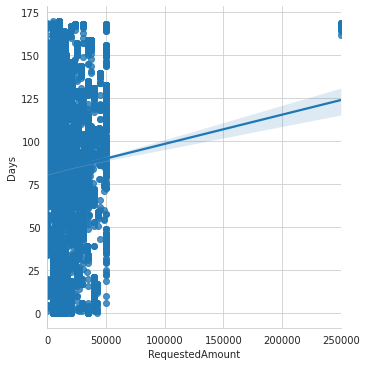

In [61]:
# we know that large requested amount applications tend to take longer time, lets see if it is true
sns.lmplot(x='RequestedAmount',y='Days',data=df_model[0:20436])
# there is definitely a correlation between days and requested amount, but that's not enough correlation to get the
# best results out of the models. we will sort the requested amount and then see if that helps increase 
# correlation

In [62]:
sort_amount=[]
for i in df_model['RequestedAmount']:
    sort_amount.append(i)
sortra=pd.DataFrame(sorted(sort_amount),columns=['Days'])
df_model.drop('RequestedAmount',axis=1,inplace=True)
df_model['RA']=sortra

In [63]:
# df_model.hightime_loan.value_counts()
df_model.head(10)

,Days,Accept_time,hightime_event,hightime_loan,RA
0,1,0,0,1,0.0
1,1,0,0,1,0.0
2,1,0,0,1,0.0
3,1,0,0,1,0.0
4,3,0,1,1,0.0
5,8,0,0,1,0.0
6,1,0,1,1,0.0
7,1,0,1,1,0.0
8,28,0,0,1,0.0
9,1,1,0,1,0.0


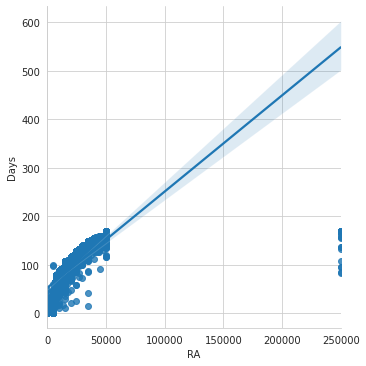

In [64]:
sns.lmplot(x='RA',y='Days',data=df_model[0:20436])
# that went quit well as you can see the results here, the correlation is great and their seems to have outliers as
# well.

simple linear regression

In [65]:
# train = df_model[1:15000]
# test = df_model[15001:20430]
target_df=(df_model[['RA','Days']])
target_df

,RA,Days
0,0.0,1
1,0.0,1
2,0.0,1
3,0.0,1
4,0.0,3
...,...,...
20425,250000.0,107
20426,250000.0,133
20427,250000.0,84
20428,250000.0,83


In [66]:
X = target_df.iloc[:, :-1].values
y = target_df.iloc[:, 1].values

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

In [68]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [69]:
y_pred = regressor.predict(X_test)

In [70]:
lr = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

In [71]:
lr

,Actual,Predicted
0,157,148.783270
1,125,102.117769
2,81,71.683747
3,16,51.394398
4,15,51.394398
...,...,...
6124,66,66.611410
6125,119,96.030965
6126,57,65.089709
6127,83,81.828421


<AxesSubplot:>

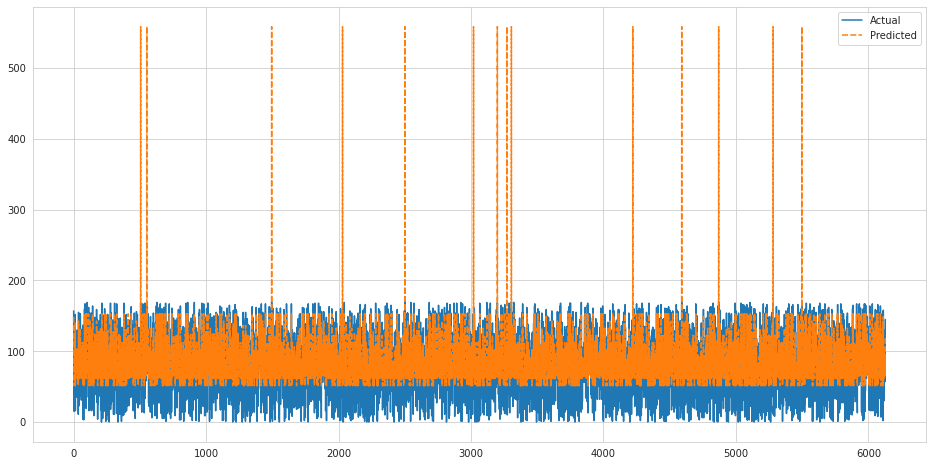

In [72]:
plt.figure(figsize=(16,8))
sns.lineplot(data=lr)

In [73]:
regressor.score(X_test,y_test)*100

53.45113216073418

multiple linear regression

In [74]:
X2=df_model[['Accept_time','hightime_event','hightime_loan', 'RA']][0:20430]
y2=df_model['Days'][0:20430]

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.3,random_state=42)

In [76]:
regressor2 = LinearRegression()
regressor2.fit(X_train, y_train)

LinearRegression()

In [77]:
y_pred2 = regressor2.predict(X_test)

In [78]:
lr2 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred2})

In [79]:
lr2

,Actual,Predicted
19630,157,147.260653
16222,125,105.085850
7646,81,68.802361
1402,16,54.475555
1328,15,50.088886
...,...,...
6434,66,65.271975
15274,119,93.641905
5700,57,68.140335
12741,83,78.924420


<AxesSubplot:>

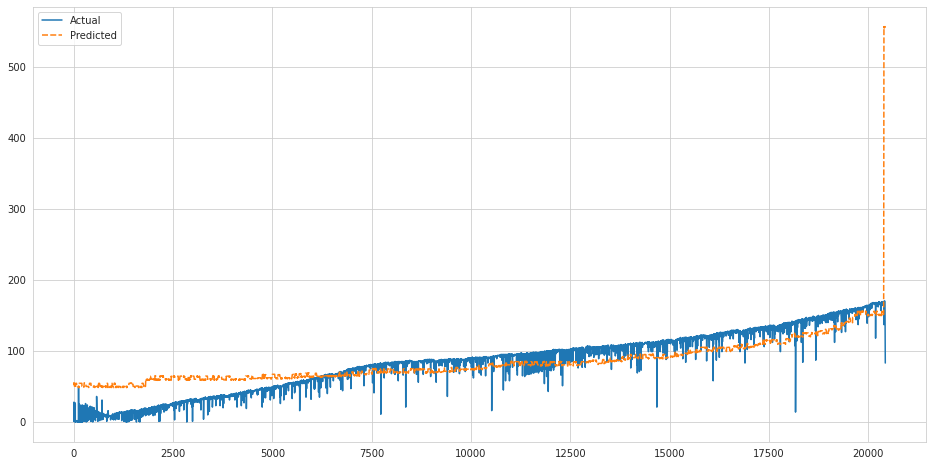

In [80]:
plt.figure(figsize=(16,8))
sns.lineplot(data=lr2)

In [81]:
regressor2.score(X_test,y_test)*100

53.59132017218433

Support vector regresssor

In [82]:
# Create and Train the Support Vector Machine (Regression) using radial basis function
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.00001)
svr_rbf.fit(X_train, y_train)

SVR(C=1000.0, gamma=1e-05)

In [83]:
y_pred3 = svr_rbf.predict(X_test)

In [84]:
svr = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred3})

In [85]:
svr

,Actual,Predicted
19630,157,157.900297
16222,125,122.099981
7646,81,84.101576
1402,16,8.100383
1328,15,8.761432
...,...,...
6434,66,66.900262
15274,119,116.926792
5700,57,57.039224
12741,83,97.032176


<AxesSubplot:>

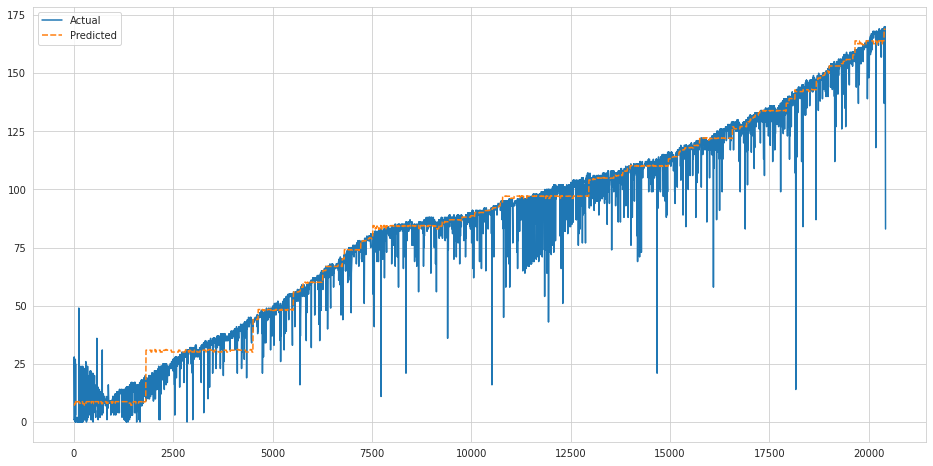

In [86]:
plt.figure(figsize=(16,8))
sns.lineplot(data=svr)

In [87]:
svr_rbf.score(X_test,y_test)*100

97.21949993574506

Decision tree regressor

In [88]:
dtr = DecisionTreeRegressor(random_state=0)
dtr.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [89]:
dtr_pred = dtr.predict(X_test)

In [90]:
dtr_g = pd.DataFrame({'Actual': y_test, 'Predicted': dtr_pred})

In [91]:
dtr_g

,Actual,Predicted
19630,157,156.484848
16222,125,121.833333
7646,81,83.163934
1402,16,8.590164
1328,15,9.372832
...,...,...
6434,66,64.838710
15274,119,115.800000
5700,57,57.230769
12741,83,94.390805


<AxesSubplot:>

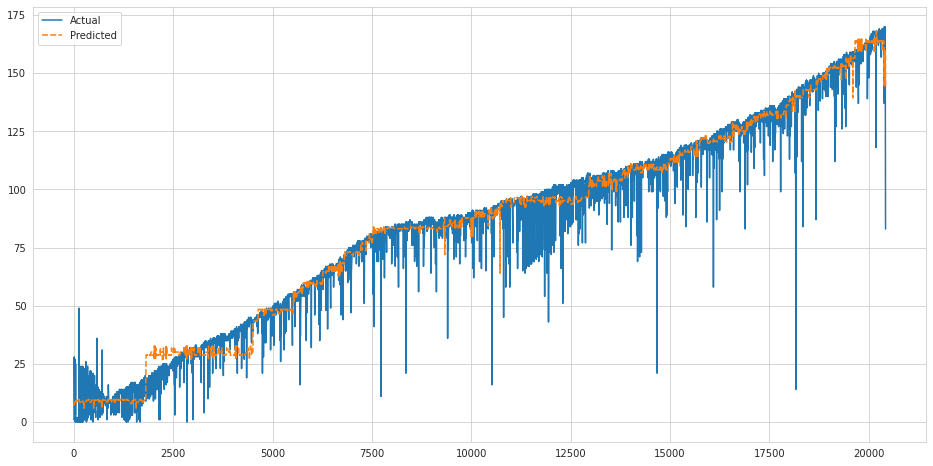

In [92]:
plt.figure(figsize=(16,8))
sns.lineplot(data=dtr_g)

In [93]:
dtr.score(X_test,y_test)*100

97.31305455483641

XGBoost regressor

In [94]:
xgb_r = xg.XGBRegressor(objective ='reg:squarederror',n_estimators = 10, seed = 123)
xgb_r.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=4, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [95]:
xgb_pred = xgb_r.predict(X_test)

In [96]:
xgb_df = pd.DataFrame({'Actual': y_test, 'Predicted': xgb_pred})

In [97]:
xgb_df

,Actual,Predicted
19630,157,151.913986
16222,125,118.136185
7646,81,80.868210
1402,16,8.361789
1328,15,9.121693
...,...,...
6434,66,63.383839
15274,119,110.981651
5700,57,55.200245
12741,83,92.558411


<AxesSubplot:>

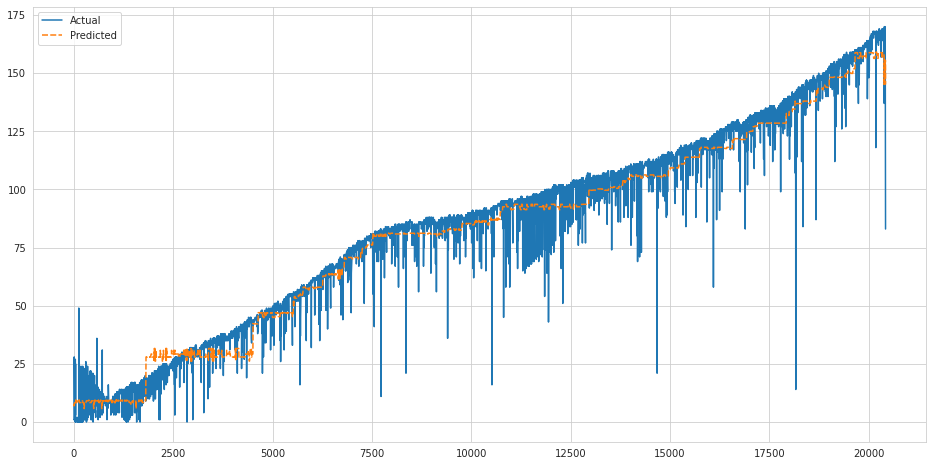

In [98]:
plt.figure(figsize=(16,8))
sns.lineplot(data=xgb_df)

In [99]:
xgb_r.score(X_test,y_test)*100

96.94805937160248

In [100]:
prophet_df=(pred_df[['Timestamp','Days']][0:20430])

In [101]:
time=prophet_df['Timestamp'].dt.strftime("%Y-%m-%d")
prophet_df.drop('Timestamp',axis=1,inplace=True)

In [102]:
prophet_df['time']=time
prophet_df.reindex(columns= ['time','Days'])
prophet_df

,Days,time
0,1,2016-01-01
1,1,2016-01-01
2,1,2016-01-01
3,1,2016-01-01
4,3,2016-01-01
...,...,...
20425,107,2016-01-08
20426,133,2016-01-08
20427,84,2016-01-08
20428,83,2016-01-08


In [103]:
prophet_df.rename(columns={'time': 'ds', 'Days': 'y'},inplace=True)
        
# prophet_df['y']=np.log(prophet_df['y'])

m=Prophet(daily_seasonality=True,yearly_seasonality=True,interval_width=0.95)
m.fit(prophet_df)

future=m.make_future_dataframe(periods=365)
future.tail()

p_pred=m.predict(future)

p_pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
432,2017-05-16,2588.300428,-78.142707,5206.129758
433,2017-05-17,2592.641554,-51.459410,5223.326809
434,2017-05-18,2607.330334,-70.298877,5225.922937
435,2017-05-19,2599.182951,-98.913393,5244.816232
436,2017-05-20,2628.169793,-87.280433,5292.827544


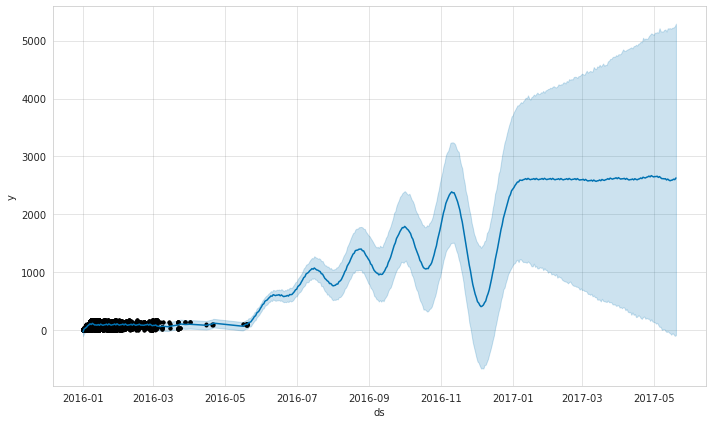

In [104]:
fig1 = m.plot(p_pred)

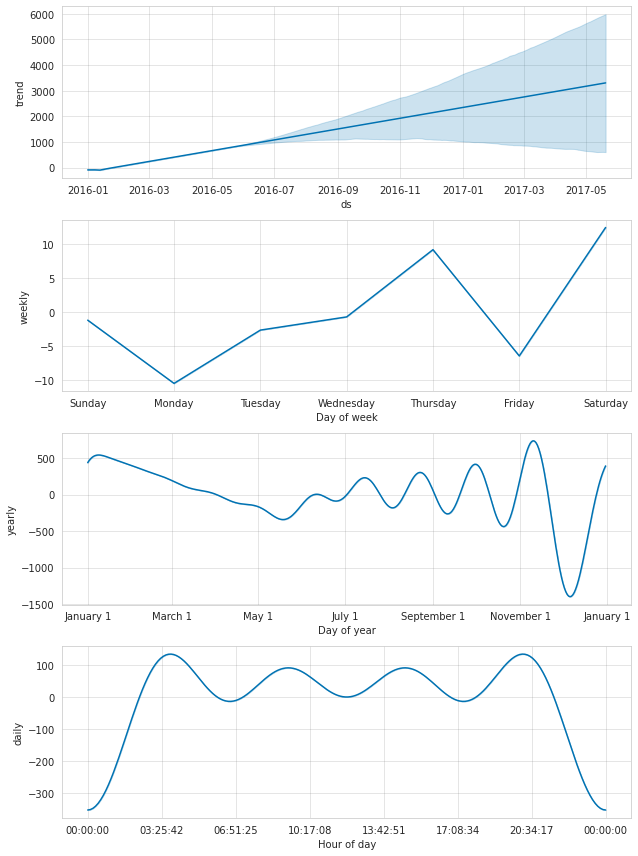

In [105]:
fig2 = m.plot_components(p_pred)

In [106]:
# r2_score(prophet_df.y[1:438],p_pred.yhat)
# xgb_r.score(X_test,y_test)*100
accuracy_score(prophet_df.y[1:438],p_pred.yhat)

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets